In [1]:
%matplotlib inline

import os

#if using Theano with GPU
#os.environ["KERAS_BACKEND"] = "tensorflow"

import random
import numpy as np
import keras

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Model

2025-09-10 21:06:41.517099: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-09-10 21:06:41.517273: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-10 21:06:41.542544: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-09-10 21:06:42.165757: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off,

## Obtendo um conjunto de dados

In [2]:
import kagglehub

#verificar se o a pasta existe
if not os.path.exists('caltech-101'):
  # Download latest version
  path = kagglehub.dataset_download("imbikramsaha/caltech-101")

  !cp -r {path+'/*'} ./

path = './caltech-101'

print("Path to dataset files:", path)

/home/watcher/Documentos/Transfer-Learning-Study/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: ./caltech-101


In [3]:
root = path
exclude = ['BACKGROUND_Google', 'Motorbikes', 'airplanes', 'Faces_easy', 'Faces']
train_split, val_split = 0.7, 0.15

categories = [x[0] for x in os.walk(root) if x[0]][1:]
categories = [c for c in categories if c not in [os.path.join(root, e) for e in exclude]]

print(categories)

['./caltech-101/cannon', './caltech-101/saxophone', './caltech-101/panda', './caltech-101/bass', './caltech-101/headphone', './caltech-101/Leopards', './caltech-101/kangaroo', './caltech-101/tick', './caltech-101/butterfly', './caltech-101/accordion', './caltech-101/inline_skate', './caltech-101/lobster', './caltech-101/windsor_chair', './caltech-101/sea_horse', './caltech-101/crab', './caltech-101/wheelchair', './caltech-101/electric_guitar', './caltech-101/ketch', './caltech-101/stegosaurus', './caltech-101/brain', './caltech-101/lamp', './caltech-101/revolver', './caltech-101/chair', './caltech-101/ibis', './caltech-101/ant', './caltech-101/pyramid', './caltech-101/llama', './caltech-101/buddha', './caltech-101/pizza', './caltech-101/strawberry', './caltech-101/hedgehog', './caltech-101/ferry', './caltech-101/scorpion', './caltech-101/scissors', './caltech-101/garfield', './caltech-101/helicopter', './caltech-101/gerenuk', './caltech-101/metronome', './caltech-101/camera', './caltec

Esta função é útil para pré-processar os dados em uma imagem e um vetor de entrada.

In [4]:
# helper function to load image and return it and input vector
def get_image(path):
    img = image.load_img(path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return img, x

Carregue todas as imagens da pasta raiz

In [5]:
data = []
for c, category in enumerate(categories):
    images = [os.path.join(dp, f) for dp, dn, filenames 
              in os.walk(category) for f in filenames 
              if os.path.splitext(f)[1].lower() in ['.jpg','.png','.jpeg']]
    for img_path in images:
        img, x = get_image(img_path)
        data.append({'x':np.array(x[0]), 'y':c})

# count the number of classes
num_classes = len(categories)

Randomize a ordem dos dados.

In [6]:
random.shuffle(data)

create training / validation / test split (70%, 15%, 15%)

In [7]:
idx_val = int(train_split * len(data))
idx_test = int((train_split + val_split) * len(data))
train = data[:idx_val]
val = data[idx_val:idx_test]
test = data[idx_test:]

Dados separados para rótulos.

In [8]:
x_train, y_train = np.array([t["x"] for t in train]), [t["y"] for t in train]
x_val, y_val = np.array([t["x"] for t in val]), [t["y"] for t in val]
x_test, y_test = np.array([t["x"] for t in test]), [t["y"] for t in test]
print(y_test)

[28, 57, 77, 43, 13, 39, 54, 6, 17, 25, 92, 78, 45, 53, 4, 40, 12, 87, 17, 38, 19, 20, 36, 74, 27, 13, 96, 87, 77, 35, 8, 14, 69, 71, 40, 54, 16, 69, 93, 0, 51, 63, 84, 23, 4, 47, 26, 21, 7, 66, 50, 88, 94, 54, 62, 35, 51, 23, 20, 29, 78, 6, 5, 74, 78, 56, 45, 91, 95, 72, 38, 88, 14, 81, 84, 82, 17, 19, 49, 54, 1, 22, 80, 83, 78, 35, 48, 34, 66, 49, 87, 39, 77, 51, 45, 26, 64, 80, 14, 9, 88, 45, 54, 75, 58, 16, 49, 9, 74, 80, 21, 17, 11, 74, 71, 49, 9, 85, 86, 41, 71, 39, 71, 34, 53, 39, 94, 7, 31, 96, 8, 92, 70, 96, 91, 62, 42, 10, 95, 50, 7, 25, 33, 36, 22, 17, 3, 87, 39, 94, 32, 25, 81, 87, 23, 14, 6, 7, 26, 95, 74, 62, 5, 35, 18, 50, 23, 1, 67, 54, 16, 17, 87, 0, 61, 54, 78, 13, 31, 70, 18, 24, 53, 77, 77, 6, 96, 6, 16, 76, 13, 8, 18, 6, 80, 17, 87, 30, 49, 75, 62, 3, 14, 35, 83, 5, 6, 54, 63, 5, 25, 61, 6, 59, 31, 72, 23, 88, 0, 66, 80, 82, 88, 90, 44, 79, 91, 53, 17, 12, 19, 85, 57, 53, 78, 54, 19, 77, 28, 3, 54, 21, 92, 94, 54, 55, 47, 63, 71, 28, 76, 19, 34, 74, 69, 63, 15, 33,

Pré-processe os dados como antes, certificando-se de que sejam float32 e normalizados entre 0 e 1.

In [9]:
# normalize data
x_train = x_train.astype('float32') / 255.
x_val = x_val.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# convert labels to one-hot vectors
y_train = keras.utils.to_categorical(y_train, num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
print(y_test.shape)

(932, 97)


Vamos fazer um resumo do que temos.

In [10]:
# summary
print("finished loading %d images from %d categories"%(len(data), num_classes))
print("train / validation / test split: %d, %d, %d"%(len(x_train), len(x_val), len(x_test)))
print("training data shape: ", x_train.shape)
print("training labels shape: ", y_train.shape)


finished loading 6209 images from 97 categories
train / validation / test split: 4346, 931, 932
training data shape:  (4346, 224, 224, 3)
training labels shape:  (4346, 97)


Se tudo funcionou corretamente, você deve ter carregado várias imagens e dividido-as em três conjuntos: "train", "val" e "test". O formato dos dados de treinamento deve ser (n, 224, 224, 3), onde n é o tamanho do seu conjunto de treinamento, e os rótulos devem ser (n, c), onde c é o número de classes (97 no caso de 101_ObjectCategories).

Observe que dividimos todos os dados em três subconjuntos — um conjunto de treinamento "train", um conjunto de validação "val" e um conjunto de teste "test". O motivo disso é avaliar corretamente a precisão do nosso classificador. Durante o treinamento, o otimizador usa o conjunto de validação para avaliar seu desempenho interno, a fim de determinar o gradiente sem sobreajustar o conjunto de treinamento. O conjunto de teste é sempre mantido fora do algoritmo de treinamento e é usado apenas no final para avaliar a precisão final do nosso modelo.

Vamos dar uma olhada rápida em algumas imagens de exemplo do nosso conjunto de dados.

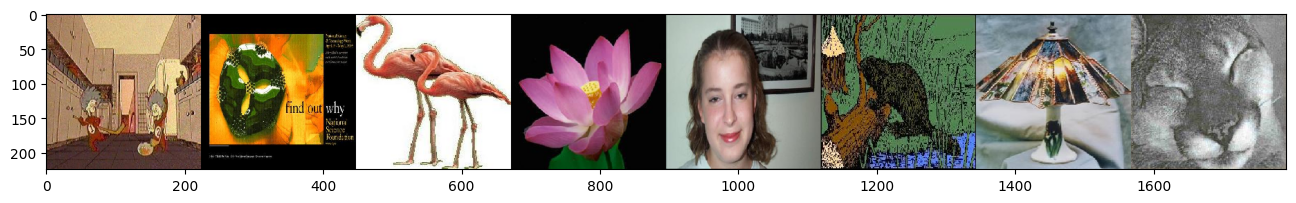

In [11]:
images = [os.path.join(dp, f) for dp, dn, filenames in os.walk(root) for f in filenames if os.path.splitext(f)[1].lower() in ['.jpg','.png','.jpeg']]
idx = [int(len(images) * random.random()) for i in range(8)]
imgs = [image.load_img(images[i], target_size=(224, 224)) for i in idx]
concat_image = np.concatenate([np.asarray(img) for img in imgs], axis=1)
plt.figure(figsize=(16,4))
plt.imshow(concat_image)

## Primeiro treinamento de uma rede neural do zero

Antes de realizar a transferência de aprendizado, vamos primeiro construir uma rede neural do zero para realizar a classificação em nosso conjunto de dados. Isso nos dará uma linha de base para comparar com nossa rede aprendida por transferência posteriormente.

A rede que construiremos contém 4 camadas convolucionais e de pooling máximo alternadas, seguidas por um dropout após cada par conv/pooling. Após a última camada de pooling, anexaremos uma camada totalmente conectada com 256 neurônios, outra camada de dropout e, finalmente, uma camada de classificação softmax para nossas classes.

Nossa função de perda será, como de costume, a perda de entropia cruzada categórica, e nosso algoritmo de aprendizado será o AdaDelta. Vários aspectos dessa rede podem ser alterados para obter melhor desempenho; talvez usar uma rede maior ou um otimizador diferente ajude, mas, para os propósitos deste caderno, o objetivo é apenas obter uma compreensão de uma linha de base aproximada para fins de comparação, portanto, não é necessário gastar muito tempo tentando otimizar esta rede.

Após compilar a rede, vamos executar model.summary() para obter um instantâneo de suas camadas.

In [12]:
# build the network
model = Sequential()
print("Input dimensions: ",x_train.shape[1:])

model.add(Conv2D(32, (3, 3), input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.25))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))

model.add(Dropout(0.5))

model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.summary()

Input dimensions:  (224, 224, 3)


/home/watcher/Documentos/Transfer-Learning-Study/.venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
E0000 00:00:1757549208.639773  446162 cuda_executor.cc:1309] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1757549208.649067  446162 gpu_device.cc:2342] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 222, 222, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 109, 109, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 54, 54, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 52, 52, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 12, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 12, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     1,179,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 97)             │        24,929 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 97)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,233,473 (4.71 MB)

 Trainable params: 1,233,473 (4.71 MB)

 Non-trainable params: 0 (0.00 B)

Criamos uma rede de médio porte com aproximadamente 1,2 milhão de pesos e vieses (os parâmetros). A maioria deles leva à camada totalmente conectada pré-softmax "dense_5".

Agora podemos prosseguir e treinar nosso modelo para 100 épocas com um tamanho de lote de 128. Também registraremos seu histórico para que possamos plotar a perda ao longo do tempo posteriormente.

In [13]:
# compile the model to use categorical cross-entropy loss function and adadelta optimizer
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(x_train, y_train,
                    batch_size=128,
                    epochs=10,
                    validation_data=(x_val, y_val))


Epoch 1/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 12s 345ms/step - accuracy: 0.0382 - loss: 4.5348 - val_accuracy: 0.0612 - val_loss: 4.4585
Epoch 2/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 12s 339ms/step - accuracy: 0.0748 - loss: 4.3864 - val_accuracy: 0.1182 - val_loss: 4.2312
Epoch 3/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 11s 335ms/step - accuracy: 0.1268 - loss: 4.1109 - val_accuracy: 0.1665 - val_loss: 3.8952
Epoch 4/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 12s 336ms/step - accuracy: 0.1903 - loss: 3.7206 - val_accuracy: 0.2664 - val_loss: 3.5087
Epoch 5/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 12s 337ms/step - accuracy: 0.2421 - loss: 3.3741 - val_accuracy: 0.3265 - val_loss: 3.1808
Epoch 6/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 12s 339ms/step - accuracy: 0.2906 - loss: 3.0717 - val_accuracy: 0.3394 - val_loss: 3.0489
Epoch 7/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 12s 338ms/step - accuracy: 0.3509 - loss: 2.7627 - val_accuracy: 0.3835 - val_loss: 2.8248
Epoch 8/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 12s 341ms/step - accuracy: 0.3935 - loss: 2.5180 - val_accu

In [14]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

Vamos traçar a perda de validação e a precisão da validação ao longo do tempo.

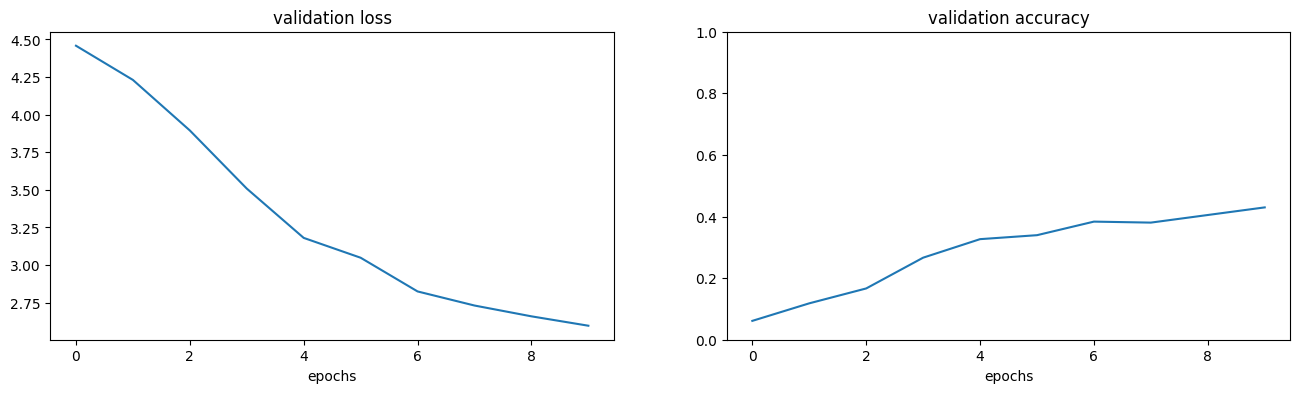

In [15]:
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(121)
ax.plot(history.history["val_loss"])
ax.set_title("validation loss")
ax.set_xlabel("epochs")

ax2 = fig.add_subplot(122)
ax2.plot(history.history["val_accuracy"])
ax2.set_title("validation accuracy")
ax2.set_xlabel("epochs")
ax2.set_ylim(0, 1)

plt.show()

Observe que a perda de validação começa a aumentar após cerca de 16 períodos, embora a precisão da validação permaneça aproximadamente entre 40% e 50%. Isso sugere que nosso modelo começa a apresentar overfitting por volta dessa época, e um desempenho melhor teria sido alcançado se tivéssemos parado antes, por volta dessa época. No entanto, nossa precisão provavelmente não teria sido superior a 50%, e provavelmente menor.

Também podemos obter uma avaliação final executando nosso modelo no conjunto de treinamento. Fazendo isso, obtemos os seguintes resultados:

In [16]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

Test loss: 2.6716115474700928
Test accuracy: 0.4002145826816559


Por fim, vemos que alcançamos uma precisão (top-1) de cerca de 49%. Isso não é tão ruim para 6.000 imagens, considerando que, se tivéssemos usado uma estratégia ingênua de fazer suposições aleatórias, teríamos obtido apenas cerca de 1% de precisão.

## Transferência de aprendizagem começando com a rede existente

Agora podemos passar para a estratégia principal para treinar um classificador de imagens em nosso pequeno conjunto de dados: começar com uma rede maior e já treinada.

Para começar, carregaremos o VGG16 do keras, que foi treinado no ImageNet e os pesos salvos online. Se esta for a primeira vez que você carrega o VGG16, precisará aguardar um pouco para que os pesos sejam baixados da web. Assim que a rede for carregada, podemos inspecionar as camadas novamente com o método summary().

In [17]:
vgg = keras.applications.VGG16(weights='imagenet', include_top=True)
vgg.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 1000)           │     4,097,000 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 138,357,544 (527.79 MB)

 Trainable params: 138,357,544 (527.79 MB)

 Non-trainable params: 0 (0.00 B)

Observe que o VGG16 é muito maior do que a rede que construímos anteriormente. Ele contém 13 camadas convolucionais e duas camadas totalmente conectadas no final, e possui mais de 138 milhões de parâmetros, cerca de 100 vezes mais parâmetros do que a rede que criamos acima. Assim como nossa primeira rede, a maioria dos parâmetros é armazenada nas conexões que levam à primeira camada totalmente conectada.

O VGG16 foi criado para resolver o ImageNet e atinge uma taxa de erro de 8,8% nas 5 principais previsões, o que significa que 91,2% das amostras de teste foram classificadas corretamente dentro das 5 principais previsões para cada imagem. Sua precisão de 1ª ordem — equivalente à métrica de precisão que temos usado (de que a previsão mais alta está correta) — é de 73%. Isso é especialmente impressionante, pois não há apenas 97, mas 1.000 classes, o que significa que palpites aleatórios nos dariam apenas 0,1% de precisão.

Para usar essa rede em nossa tarefa, "removemos" a camada de classificação final, a camada softmax de 1000 neurônios no final, que corresponde ao ImageNet, e a substituímos por uma nova camada softmax para nosso conjunto de dados, que contém 97 neurônios no caso do conjunto de dados 101_ObjectCategories.

Em termos de implementação, é mais fácil simplesmente criar uma cópia do VGG de sua camada de entrada até a penúltima camada e, em seguida, trabalhar com ela, em vez de modificar o objeto VGG diretamente. Portanto, tecnicamente, nunca "removemos" nada, apenas o contornamos/ignoramos. Isso pode ser feito da seguinte maneira: usando a classe Model do Keras para inicializar um novo modelo cuja camada de entrada é a mesma do VGG, mas cuja camada de saída é nossa nova camada softmax, chamada new_classification_layer. Observação: embora pareça que estamos duplicando essa grande rede, internamente o Keras está, na verdade, apenas copiando todas as camadas por referência e, portanto, não precisamos nos preocupar em sobrecarregar a memória.

In [18]:
#fazer uma referência à camada de entrada do VGG
inp = vgg.input

#fazer uma nova camada de softmax com num_classes neurônios
new_classification_layer = Dense(num_classes, activation='softmax')

#conectar nossa nova camada para a penúltima camada do VGG, e fazer referência a isso como 'out'
out = new_classification_layer(vgg.layers[-2].output)

#criar uma nova rede entre inp e out
model_new = Model(inp, out)

Vamos retreinar esta rede, `model_new`, no novo conjunto de dados e rótulos. Mas, primeiro, precisamos congelar os pesos e vieses em todas as camadas da rede, exceto a nova no final, com a expectativa de que os recursos aprendidos no VGG ainda sejam razoavelmente relevantes para a nova tarefa de classificação de imagens. Não é o ideal, mas provavelmente é melhor do que podemos treinar em nosso conjunto de dados limitado.

Ao definir o sinalizador `trainable` em cada camada como falso (exceto em nossa nova camada de classificação), garantimos que todos os pesos e vieses nessas camadas permaneçam fixos e simplesmente treinamos os pesos na camada final. Em alguns casos, é desejável *não* congelar todas as camadas de pré-classificação. Se o seu conjunto de dados tiver amostras suficientes e não se assemelhar muito ao ImageNet, pode ser vantajoso ajustar algumas das camadas do VGG junto com o novo classificador, ou possivelmente até mesmo todas elas. Para fazer isso, você pode alterar o código abaixo para tornar mais camadas treináveis.

No caso do CalTech-101, faremos apenas a extração de características, temendo que o ajuste fino excessivo neste conjunto de dados possa causar overfitting. Mas talvez estejamos errados? Um bom exercício seria testar ambos e comparar os resultados.

Então, congelamos as camadas e compilamos o novo modelo com exatamente o mesmo otimizador e função de perda da nossa primeira rede, para uma comparação justa. Em seguida, executamos `summary` novamente para analisar a arquitetura da rede.

In [19]:
# tornar todas as camadas não treináveis ​​congelando os pesos (exceto a última camada)
for l, layer in enumerate(model_new.layers[:-1]):
    layer.trainable = False

# garantir que a ultima camada seja treinável/ nao congelada
for l, layer in enumerate(model_new.layers[-1:]):
    layer.trainable = True

model_new.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model_new.summary()


Model: "functional_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 97)             │       397,409 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,657,953 (513.68 MB)

 Trainable params: 397,409 (1.52 MB)

 Non-trainable params: 134,260,544 (512.16 MB)

Observando o resumo, vemos que a rede é idêntica ao modelo VGG que instanciamos anteriormente, exceto que a última camada, anteriormente um softmax de 1.000 neurônios, foi substituída por um novo softmax de 97 neurônios. Além disso, ainda temos aproximadamente 134 milhões de pesos, mas agora a grande maioria deles são "parâmetros não treináveis" porque congelamos as camadas em que estão contidos. Agora temos apenas 397.000 parâmetros treináveis, o que representa apenas um quarto do número de parâmetros necessários para treinar o primeiro modelo.

Como antes, seguimos em frente e treinamos o novo modelo, usando os mesmos hiperparâmetros (tamanho do lote e número de épocas) de antes, juntamente com o mesmo algoritmo de otimização. Também monitoramos seu histórico à medida que avançamos.

In [20]:
history2 = model_new.fit(x_train, y_train, 
                         batch_size=128, 
                         epochs=10, 
                         validation_data=(x_val, y_val))

Epoch 1/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 123s 4s/step - accuracy: 0.1746 - loss: 4.0512 - val_accuracy: 0.3781 - val_loss: 3.0586
Epoch 2/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 131s 4s/step - accuracy: 0.4388 - loss: 2.5777 - val_accuracy: 0.5306 - val_loss: 2.2174
Epoch 3/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 132s 4s/step - accuracy: 0.5651 - loss: 1.9286 - val_accuracy: 0.5467 - val_loss: 1.8732
Epoch 4/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 135s 4s/step - accuracy: 0.6422 - loss: 1.5983 - val_accuracy: 0.6015 - val_loss: 1.6565
Epoch 5/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 136s 4s/step - accuracy: 0.6744 - loss: 1.4234 - val_accuracy: 0.6455 - val_loss: 1.5522
Epoch 6/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 134s 4s/step - accuracy: 0.6997 - loss: 1.2837 - val_accuracy: 0.6563 - val_loss: 1.4339
Epoch 7/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 133s 4s/step - accuracy: 0.7418 - loss: 1.1293 - val_accuracy: 0.6874 - val_loss: 1.2994
Epoch 8/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 136s 4s/step - accuracy: 0.7609 - loss: 1.0320 - val_accuracy: 0.7014 - v

Nossa precisão de validação gira em torno de 80% no final, o que representa uma melhoria de mais de 30% em relação à rede original treinada do zero (o que significa que fizemos a previsão errada em 20% das amostras, em vez de 50%).

Vale a pena notar também que esta rede, na verdade, treina um pouco mais rápido do que a rede original, apesar de ter mais de 100 vezes mais parâmetros! Isso ocorre porque o congelamento dos pesos elimina a necessidade de retropropagação por todas essas camadas, economizando tempo de execução.

Vamos plotar a perda e a precisão da validação novamente, desta vez comparando o modelo original treinado do zero (em azul) e o novo modelo aprendido por transferência em verde.

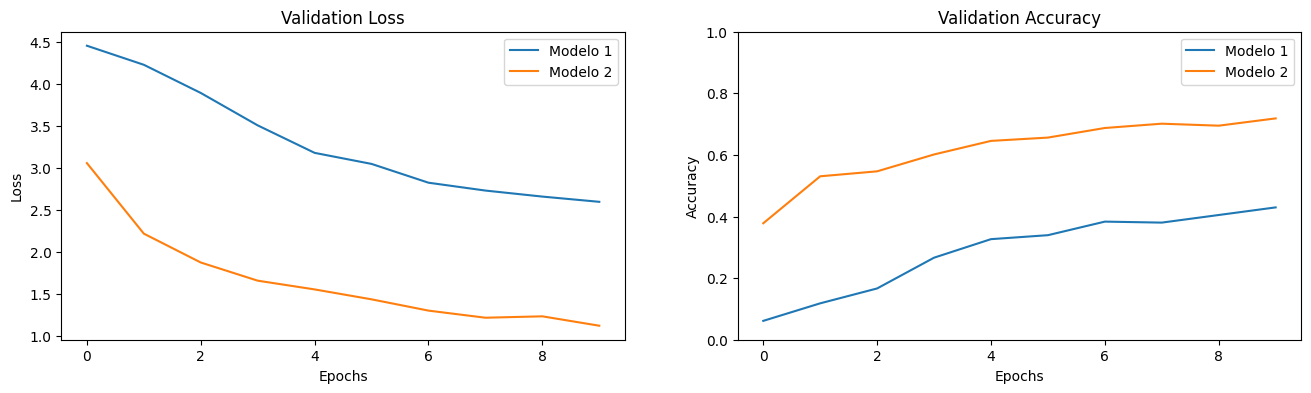

In [21]:
fig = plt.figure(figsize=(16,4))

# Validation Loss
ax = fig.add_subplot(121)
ax.plot(history.history["val_loss"], label="Modelo 1")
ax.plot(history2.history["val_loss"], label="Modelo 2")
ax.set_title("Validation Loss")
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")
ax.legend()

# Validation Accuracy
ax2 = fig.add_subplot(122)
ax2.plot(history.history["val_accuracy"], label="Modelo 1")
ax2.plot(history2.history["val_accuracy"], label="Modelo 2")
ax2.set_title("Validation Accuracy")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Accuracy")
ax2.set_ylim(0, 1)
ax2.legend()

plt.show()

Observe que, enquanto o modelo original começou a apresentar overfitting por volta da época 16, o novo modelo continuou a diminuir lentamente sua perda ao longo do tempo e provavelmente teria melhorado ligeiramente sua precisão com mais iterações. O novo modelo atingiu aproximadamente 80% de precisão top-1 (no conjunto de validação) e continuou a melhorar lentamente ao longo de 100 épocas.

É possível que pudéssemos ter melhorado o modelo original com melhor regularização ou mais dropouts, mas certamente não teríamos recuperado a melhoria de mais de 30% na precisão.

Novamente, fazemos uma validação final no conjunto de teste.

In [22]:
loss, accuracy = model_new.evaluate(x_test, y_test, verbose=0)

print('Test loss:', loss)
print('Test accuracy:', accuracy)

Test loss: 1.2789920568466187
Test accuracy: 0.6931330561637878


Para prever uma nova imagem, basta executar o código a seguir para obter as probabilidades de cada classe.

In [23]:
img, x = get_image(images[idx[0]])
probabilities = model_new.predict(x)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
